<a href="https://colab.research.google.com/github/chatwipa-sur/SRCC_detection/blob/main/Student_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trian Student model
- Train CenterNet model with original ground truth label and pseudo-label from teacher model

In [1]:
# Standard library for file and directory operations
import os
from datetime import datetime
import sys

# Library for parsing XML files (used for annotations)
import xml.etree.ElementTree as ET

# Core PyTorch library for tensor operations
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import random_split
import torch.nn as nn
import torchvision
from torchvision.ops import nms, box_iou
from torchvision.models import ResNet50_Weights, ResNet34_Weights, ResNet18_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Library for numerical computations
import numpy as np
import pandas as pd
import time

# Library for data visualization
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
# Mount the drive with google colab notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Create Dataset

In [3]:
# Make heatmaps using the utility functions from the centernet repo
# Draw a Gaussian centered at a point on a heatmap
def draw_msra_gaussian(heatmap, center, sigma=10):
  # Total size (radius) of the Gaussian region
  tmp_size = sigma * 6

  # Round the x and y center to nearest int
  mu_x = int(center[0] + 0.5)
  mu_y = int(center[1] + 0.5)

  # Get heatmap dimensions
  w, h = heatmap.shape[0], heatmap.shape[1]

  # Upper-left and bottom-right corners of the Gaussian patch
  ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
  br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]

  # If Gaussian patch is completely outside the heatmap, return
  if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
    return heatmap

  # Create a 2D Gaussian
  size = 2 * tmp_size + 1 # Size of the Gaussian patch
  x = np.arange(0, size, 1, np.float32) # x coordinates
  y = x[:, np.newaxis] # y coordinates
  x0 = y0 = size // 2 # Center of the Gaussian
  g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2)) # 2D Gaussian formula

  # Compute valid bounds for placing the Gaussian patch on the heatmap
  g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
  g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
  img_x = max(0, ul[0]), min(br[0], h)
  img_y = max(0, ul[1]), min(br[1], w)

  # Place the Gaussian on the heatmap using max to retain highest intensity
  heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
    g[g_y[0]:g_y[1], g_x[0]:g_x[1]])

  return heatmap

# Draw a dense regression value map around a center point
def draw_dense_reg(regmap, heatmap, center, value, radius, is_offset=False):
  # Size of the square region
  diameter = 2 * radius + 1
  # Create Gaussian mask
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)

  # Convert value to float32 and reshape to [dim, 1, 1]
  value = np.array(value, dtype=np.float32).reshape(-1, 1, 1)
  dim = value.shape[0]

  # Create a repeated value map of shape [dim, H, W]
  reg = np.ones((dim, diameter*2+1, diameter*2+1), dtype=np.float32) * value

  # If it's an offset, adjust the values using distance from center
  if is_offset and dim == 2:
    delta = np.arange(diameter*2+1) - radius
    reg[0] = reg[0] - delta.reshape(1, -1)
    reg[1] = reg[1] - delta.reshape(-1, 1)

  # Center coordinates
  x, y = int(center[0]), int(center[1])

  # Heatmap dimensions
  height, width = heatmap.shape[0:2]

  # Compute boundaries (clipping at image edges)
  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  # Crop regions from heatmap, regmap, Gaussian, and value maps
  masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
  masked_regmap = regmap[:, y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom,
                             radius - left:radius + right]
  masked_reg = reg[:, radius - top:radius + bottom,
                      radius - left:radius + right]

  # Only update if region is valid (non-zero size)
  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug

    # Create a mask where Gaussian is stronger than existing heatmap
    idx = (masked_gaussian >= masked_heatmap).reshape(1, masked_gaussian.shape[0],
                                                      masked_gaussian.shape[1])

    # Update regmap only where mask is True (using Gaussian gate)
    masked_regmap = (1-idx) * masked_regmap + idx * masked_reg

  # Write updated region back to original regmap
  regmap[:, y - top:y + bottom, x - left:x + right] = masked_regmap

  return regmap

def gaussian2D(shape, sigma=1):
    # Get center and coordinate grid
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    # Apply 2D Gaussian function
    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))

    # Remove near-zero values for stability
    h[h < np.finfo(h.dtype).eps * h.max()] = 0

    return h

def make_hm_regr(target, input_size=512, MODEL_SCALE=4):

    IN_SCALE = 1
    # make output heatmap for single class
    hm = np.zeros([input_size//MODEL_SCALE, input_size//MODEL_SCALE], dtype=np.float32)
    # make regr heatmap
    regr = np.zeros([2, input_size//MODEL_SCALE, input_size//MODEL_SCALE], dtype=np.float32)

    if target.empty:
        return hm, regr

    center = np.array([target["x"] + target["w"]//2, target["y"] + target["h"]//2,
                       target["w"], target["h"]]).T

    # make a center point
    # try gaussian points.
    for c in center:
        hm = draw_msra_gaussian(hm, [int(c[0])//MODEL_SCALE//IN_SCALE,
                                     int(c[1])//MODEL_SCALE//IN_SCALE],
                                sigma=np.clip(c[2]*c[3]//2000, 5, 10))

    # convert targets to its center.
    regrs = center[:, 2:]/input_size/IN_SCALE

    # plot regr values to mask
    for r, c in zip(regrs, center):
        for i in range(-2, 3):
            for j in range(-2, 3):
                try:
                    regr[:, int(c[0])//MODEL_SCALE//IN_SCALE+i,
                         int(c[1])//MODEL_SCALE//IN_SCALE+j] = r
                except:
                    pass
    regr[0] = regr[0].T; regr[1] = regr[1].T;

    return hm, regr

def pred2box(hm, regr, thresh=0.99, MODEL_SCALE=4, input_size=512):
    pred = hm > thresh
    pred_center = np.where(pred)
    pred_r = regr[:, pred].T  # Shape: [N, 2] for w, h
    boxes = []
    scores = hm[pred]

    for i, b in enumerate(pred_r):
        cx = pred_center[1][i] * MODEL_SCALE
        cy = pred_center[0][i] * MODEL_SCALE

        w = b[0] * input_size
        h = b[1] * input_size

        x1 = cx - w /2
        y1 = cy - h /2

        arr = np.clip([x1, y1, w, h], 0, input_size)
        boxes.append(arr)

    return np.asarray(boxes), scores


# Assuming `image` is a torch.Tensor of shape (3, H, W)
def unnormalize_tensor(image):
  mean = [0.485, 0.456, 0.406]
  std  = [0.229, 0.224, 0.225]
  for t, m, s in zip(image, mean, std):
    t.mul_(s).add_(m)
  return image

In [4]:
class SignetRingCellPatchCenterNetDataset(Dataset):
  def __init__(self, image_dir, annotation_dir, patch_size=512, transform=None):
    # Initialize parameters
    self.patch_size = patch_size
    self.stride = patch_size//2  # 50% overlap for 512x512 patches
    self.transform = transform
    self.image_information = []

    # Loop over positive and negative folders
    for class_type in ['positive', 'negative']:
    # for class_type in ['positive']:
      full_image_dir = os.path.join(image_dir, class_type)
      full_anno_dir = os.path.join(annotation_dir, class_type)

      # Iterate over image files in the folder
      for fname in os.listdir(full_image_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
          # Collect image path
          image_path = os.path.join(full_image_dir, fname)

          # Collect annotation path
          if class_type == "positive":
            anno_filename = fname.replace('.png', '.xml').replace('.jpg', '.xml').replace('.jpeg', '.xml')
            anno_path = os.path.join(full_anno_dir, anno_filename)
          else:
            anno_path = None  # no annotation for negatives

          # Get the size of image
          image = cv2.imread(image_path)
          height, width = image.shape[:2]

          # Generate sliding window patches
          for top in range(0, height - self.patch_size + 1, self.stride):
            for left in range(0, width - self.patch_size + 1, self.stride):
              self.image_information.append({
                  'image_path': image_path,
                  'annotation_path': anno_path,
                  'crop_box': (left, top, left + self.patch_size, top + self.patch_size),
                  'flag': 1 if class_type == 'positive' else 0
              })

  def __len__(self):
    return len(self.image_information) # Total number of patches

  def __getitem__(self, idx):
    # Get image for this index
    image_info = self.image_information[idx]
    image = cv2.imread(image_info['image_path'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Crop patch using numpy slicing: [top:bottom, left:right]
    left, top, right, bottom = image_info['crop_box']
    image_patch = image[top:bottom, left:right]

    # Get type of image
    flag = image_info['flag']

    # Load and process annotations
    boxes_list = []
    category_ids = []
    if image_info['annotation_path'] is not None:
        tree = ET.parse(image_info['annotation_path'])
        root = tree.getroot()

        crop_xmin, crop_ymin, crop_xmax, crop_ymax = image_info['crop_box']
        for obj in root.findall('object'):
            name = obj.find('name').text
            if name == 'ring_cell_cancer':
                bbox = obj.find('bndbox')
                xmin = int(bbox.find('xmin').text)
                ymin = int(bbox.find('ymin').text)
                xmax = int(bbox.find('xmax').text)
                ymax = int(bbox.find('ymax').text)

                if (xmin >= crop_xmin and xmax <= crop_xmax) and (ymin >= crop_ymin and ymax <= crop_ymax):
                    new_xmin = xmin - crop_xmin
                    new_ymin = ymin - crop_ymin
                    new_xmax = xmax - crop_xmin
                    new_ymax = ymax - crop_ymin
                    boxes_list.append((new_xmin, new_ymin,
                                       new_xmax - new_xmin,
                                       new_ymax - new_ymin))
                    category_ids.append(1)  # ring_cell_cancer

    # Apply transform (if any)
    if self.transform and len(boxes_list) > 0:
        transformed = self.transform(
            image=image_patch,
            bboxes=boxes_list,
            category_ids=category_ids
        )
        image_patch = transformed['image']
        boxes_list = transformed['bboxes']
    elif self.transform:
        transformed = self.transform(image=image_patch, bboxes=[], category_ids=[])
        image_patch = transformed['image']

    # Generate heatmap + regression map
    if len(boxes_list) == 0:
        hm = np.zeros([self.patch_size // 4, self.patch_size // 4], dtype=np.float32)
        regr = np.zeros([2, self.patch_size // 4, self.patch_size // 4], dtype=np.float32)
    else:
        target = pd.DataFrame(boxes_list, columns=['x', 'y', 'w', 'h'])
        hm, regr = make_hm_regr(target)

    return image_patch, hm, regr, boxes_list, flag

### 1.1 Transform function

In [5]:
# Transform function
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),  # converts image and bounding boxes to torch.Tensor
], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))


# Transform function
val_test_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


### 1.2 Visualize dataset
- Check `SignetRingCellPatchDataset` function

In [6]:
# Path of dataset
image_dir = "/content/drive/MyDrive/Dissertation_Chatwipa/dataset/train"
annotation_dir = "/content/drive/MyDrive/Dissertation_Chatwipa/dataset/annotations/train"

# Load dataset and patching
dataset = SignetRingCellPatchCenterNetDataset(image_dir, annotation_dir, transform=train_transform)

torch.Size([3, 512, 512])
Flag: 1


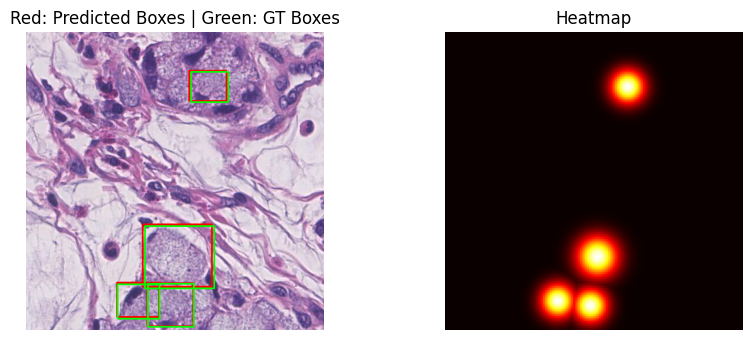

In [7]:
# Get image and corresponding data from dataset
image, hm, regr, gt_boxes, flag = dataset[15]
print(image.shape)  # (3, H, W) – check image size
print(f'Flag: {flag}')

# Unnormalize image (if normalized during preprocessing)
image = unnormalize_tensor(image.clone())

# Get predicted boxes from heatmap and regression outputs
pred_boxes, _ = pred2box(hm, regr)

# Convert tensor image to numpy
image = image.clone().permute(1, 2, 0).numpy()
image = (image * 255).astype(np.uint8)

# Copy image for drawing boxes
image_copy = image.copy()

# Draw predicted boxes in red
for box in pred_boxes:
    x, y, w, h = map(int, box)
    cv2.rectangle(image_copy, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Draw ground truth boxes in green
for box in gt_boxes:
    x1, y1, w, h = map(int, box)
    cv2.rectangle(image_copy, (x1, y1), (x1 + w, y1 + h), (0, 255, 0), 2)

# Create subplot for visualization
fig, axs = plt.subplots(1, 2, figsize=(9, 3.5))

# Display image with predicted and GT boxes
axs[0].imshow(image_copy)
axs[0].set_title("Red: Predicted Boxes | Green: GT Boxes")
axs[0].axis('off')

# Display raw heatmap
axs[1].imshow(hm, cmap='hot')
axs[1].set_title("Heatmap")
axs[1].axis('off')

plt.tight_layout()
plt.show()

## 2. Data Loader

In [8]:
# Paths
dataset_base_dir = "/content/drive/MyDrive/Dissertation_Chatwipa/dataset"

# Train and Validation dataset
train_dataset = SignetRingCellPatchCenterNetDataset(
    image_dir=os.path.join(dataset_base_dir, "train"),
    annotation_dir=os.path.join(dataset_base_dir, "annotations/train"),
    transform=train_transform
)

val_dataset = SignetRingCellPatchCenterNetDataset(
    image_dir=os.path.join(dataset_base_dir, "val"),
    annotation_dir=os.path.join(dataset_base_dir, "annotations/val"),
    transform=val_test_transform
)

# Test dataset
test_dataset = SignetRingCellPatchCenterNetDataset(
    image_dir=os.path.join(dataset_base_dir, "test"),
    annotation_dir=os.path.join(dataset_base_dir, "annotations/test"),
    transform=val_test_transform
)

# Define a custom collate function to handle the variable-length gt_boxes
def custom_collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    hms = torch.stack([torch.from_numpy(item[1]).float() for item in batch])
    regrs = torch.stack([torch.from_numpy(item[2]).float() for item in batch])
    gt_boxes = [item[3] for item in batch]
    flags = [item[4] for item in batch]

    return images, hms, regrs, gt_boxes, flags

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate_fn)

Check `train_loader` function

In [9]:
for batch in train_loader:
    if batch is None:
        continue
    images, hm, regr, gt_boxes, _ = batch
    print(f"Loaded batch with {len(images)} images")
    break

Loaded batch with 16 images


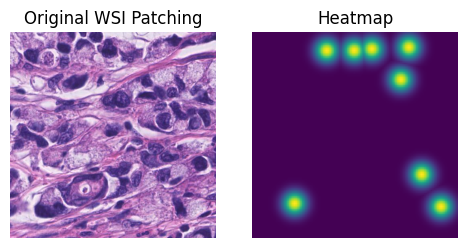

In [10]:
# Convert image to numpy
image = unnormalize_tensor(images[15].clone())
image = image.clone().permute(1, 2, 0).numpy()
image = (image * 255).astype(np.uint8)

# Plot using subplots
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5))

# Show the original image
axs[0].imshow(image)
axs[0].set_title("Original WSI Patching")
axs[0].axis('off')

# Show the heatmap
axs[1].imshow(hm[15])  # or use 'viridis', 'jet', etc.
axs[1].set_title("Heatmap")
axs[1].axis('off')

plt.tight_layout()
plt.show()

Check `val_loader` function

In [11]:
for batch in val_loader:
    if batch is None:
        continue
    images, hm, regr, gt_boxes, _  = batch
    print(f"Loaded batch with {len(images)} images")
    break

Loaded batch with 16 images


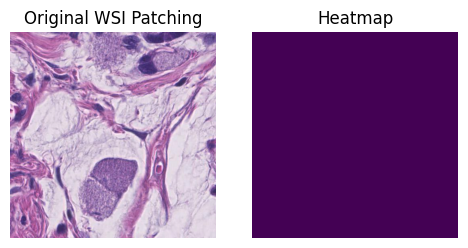

In [12]:
# Convert image to numpy
image = unnormalize_tensor(images[15].clone())
image = image.clone().permute(1, 2, 0).numpy()
image = (image * 255).astype(np.uint8)

# Plot using subplots
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5))

# Show the original image
axs[0].imshow(image)
axs[0].set_title("Original WSI Patching")
axs[0].axis('off')

# Show the heatmap
axs[1].imshow(hm[15])  # or use 'viridis', 'jet', etc.
axs[1].set_title("Heatmap")
axs[1].axis('off')

plt.tight_layout()
plt.show()

Check `test_loader` function

In [13]:
for batch in test_loader:
    if batch is None:
        continue
    images, hm, regr, gt_boxes, _  = batch
    print(f"Loaded batch with {len(images)} images")
    break

Loaded batch with 16 images


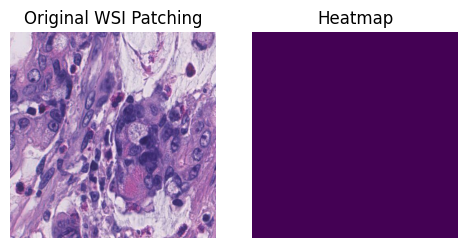

In [14]:
# Convert image to numpy
image = unnormalize_tensor(images[15].clone())
image = image.clone().permute(1, 2, 0).numpy()
image = (image * 255).astype(np.uint8)

# Plot using subplots
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5))

# Show the original image
axs[0].imshow(image)
axs[0].set_title("Original WSI Patching")
axs[0].axis('off')

# Show the heatmap
axs[1].imshow(hm[15])  # or use 'viridis', 'jet', etc.
axs[1].set_title("Heatmap")
axs[1].axis('off')

plt.tight_layout()
plt.show()

## 3. Model Training

### 3.1 CenterNet Model

- The model is based on [CenterNet Baseline](https://www.kaggle.com/hocop1/centernet-baseline/data).

#### CenterNet class

In [15]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ELU(inplace=True), # Change from ReLU to ELU
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ELU(inplace=True), # Change from ReLU to ELU
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
            # input is CHW
            diffY = x2.size()[2] - x1.size()[2]
            diffX = x2.size()[3] - x1.size()[3]

            x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                            diffY // 2, diffY - diffY//2))
        else:
            x = x1
        x = self.conv(x)
        return x

class centernet(nn.Module):
    def __init__(self, n_classes=1, model_name="resnet34"):
        super(centernet, self).__init__()

        # Create model backbone
        if model_name == "resnet50":
            basemodel = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
            self.num_ch = 2048
        elif model_name == "resnet34":
            basemodel = torchvision.models.resnet34(weights=ResNet34_Weights.DEFAULT)
            self.num_ch = 512
        elif model_name == "resnet18":
            basemodel = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
            self.num_ch = 512

        # Remove the last two layers (average pooling and linear layer)
        self.base_model = nn.Sequential(*list(basemodel.children())[:-2])

        # Freeze earlier layers except layer3 and layer4
        for name, param in basemodel.named_parameters():
            if "layer4" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        if self.num_ch == 2048:
            self.up1 = up(self.num_ch, 1024)
            self.up2 = up(1024, 512)
            self.up3 = up(512, 256)
        else:
            self.up1 = up(self.num_ch, 512)
            self.up2 = up(512, 256)
            self.up3 = up(256, 256)

        # Output classification
        self.outc = nn.Conv2d(256, n_classes, 1)

        # Output residue
        self.outr = nn.Conv2d(256, 2, 1)

    def forward(self, x):
        x = self.base_model(x)
        # Add positional info
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        outc = self.outc(x)
        outc = torch.sigmoid(outc)
        outr = self.outr(x)
        return outc, outr

#### Loss function

In [16]:
# From centernet repo
# Modified focal loss to detect object centers via heatmap
def neg_loss(pred, gt, pos_gamma=2, neg_gamma=4):
  ''' Modified focal loss. Exactly the same as CornerNet.
      Runs faster and costs a little bit more memory
      Args:
      pred: (B, 1, H, W)
      gt: (B, 1, H, W)
      pos_gamma: focusing parameter for positive examples
      neg_gamma: focusing parameter for negative examples
    '''

  pred = pred.unsqueeze(1).float()
  gt = gt.unsqueeze(1).float()

  pos_inds = gt.eq(1).float() # Locations where there is a true object center
  neg_inds = gt.lt(1).float()  # All other pixels
  neg_weights = torch.pow(1 - gt, 4) # Higher weight for pixels farther from center

  loss = 0

  pos_loss = torch.log(pred + 1e-12) * torch.pow(1 - pred, pos_gamma) * pos_inds
  neg_loss = torch.log(1 - pred + 1e-12) * torch.pow(pred, neg_gamma) * neg_weights * neg_inds

  num_pos  = pos_inds.float().sum()
  # num_pos = torch.clamp(num_pos, min=1.0)
  pos_loss = pos_loss.sum()
  neg_loss = neg_loss.sum()

  if num_pos == 0:
    loss = loss - neg_loss
  else:
    loss = loss - (pos_loss + neg_loss) / num_pos

  return loss

# Smooth L1 regression loss for offsets, widths, etc.
def _reg_loss(regr, gt_regr, mask):
  ''' L1 regression loss
      regr: (B, N, 2)
      gt_regr: (B, N, 2)
      mask: (B, N)
  '''
  num = mask.float().sum()
  mask = mask.unsqueeze(2).expand_as(gt_regr)  # (B, N, 2)

  regr = regr * mask
  gt_regr = gt_regr * mask

  regr_loss = nn.functional.smooth_l1_loss(regr, gt_regr, reduction='sum')
  regr_loss = regr_loss / (num + 1e-4)

  return regr_loss


def centerloss(prediction, mask, regr, weight=10, size_average=True, eps=1e-6):
    """
    Combines heatmap focal loss and regression L1 loss into a total loss.

    Args:
        prediction: (B, 3, H, W) where [:, 0] = heatmap, [:, 1:] = regr
        mask: (B, H, W) – binary mask for object centers
        regr: (B, 2, H, W) – regression ground truth
        weight: float – weight of regression loss
        size_average: bool – average the final loss across batch
        eps: float – small number to avoid division by zero

    Returns:
        total_loss, mask_loss, regr_loss
    """

    # Heatmap and regression prediction
    pred_mask = prediction[:, 0]
    pred_regr = prediction[:, 1:] # (B, 2, H, W)

    # Compute heatmap focal loss
    mask_loss = neg_loss(pred_mask, mask)

    # Prepare mask for regression
    mask_exp = mask.unsqueeze(1).float() # (B, 1, H, W)

    # Flatten tensors for _reg_loss: (B, 2, H, W) -> (B, H*W, 2)
    pred_regr_flat = pred_regr.permute(0, 2, 3, 1).reshape(pred_regr.size(0), -1, 2)
    regr_gt_flat = regr.permute(0, 2, 3, 1).reshape(regr.size(0), -1, 2)
    mask_flat = mask.view(mask.size(0), -1)  # (B, H*W)

    # Regression loss using helper
    regr_loss = _reg_loss(pred_regr_flat, regr_gt_flat, mask_flat)

    # Total loss (with weighting)
    total_loss = mask_loss + weight * regr_loss

    if not size_average:
        total_loss *= prediction.shape[0]

    return total_loss, mask_loss, regr_loss


#### Evaluation function

In [17]:
# Convert bounding boxes from (x, y, w, h) format to (x1, y1, x2, y2) format.
def boxes_conversion_xy(boxes_x1y1wh):
    """
    Args:
        boxes: A set of bounding boxes in (x, y, width, height) format

    Returns:
        torch.Tensor: Bounding boxes in (x1, y1, x2, y2) format as a float32 tensor.
                      (x1, y1) is the top-left corner, (x2, y2) is the bottom-right.
    """

    if isinstance(boxes_x1y1wh, torch.Tensor):
        boxes_x1y1x2y2 = boxes_x1y1wh.clone()
        boxes_x1y1x2y2[:, 2] = boxes_x1y1x2y2[:, 0] + boxes_x1y1x2y2[:, 2]  # x2 = x + w
        boxes_x1y1x2y2[:, 3] = boxes_x1y1x2y2[:, 1] + boxes_x1y1x2y2[:, 3]  # y2 = y + h
    else:
        boxes_x1y1wh = np.array(boxes_x1y1wh)
        boxes_x1y1x2y2 = boxes_x1y1wh.copy()
        boxes_x1y1x2y2[:, 2] = boxes_x1y1x2y2[:, 0] + boxes_x1y1x2y2[:, 2]
        boxes_x1y1x2y2[:, 3] = boxes_x1y1x2y2[:, 1] + boxes_x1y1x2y2[:, 3]
        boxes_x1y1x2y2 = torch.tensor(boxes_x1y1x2y2, dtype=torch.float32)

    return boxes_x1y1x2y2

def match_predictions(pred_boxes, gt_boxes, positive_flag, iou_thresh=0.5):
    """
    Args:
        pred_boxes: List of predicted boxes in xywh
        gt_boxes: List of ground truth boxes in xywh
        positive_flag: True if image has GT boxes (positive sample), else False
    Returns:
        tp, fp, tn, fn
    """
    # If image is potive sample
    if positive_flag:
        # No label from both gound-truth and prediction -> TN
        if len(gt_boxes) == 0 and len(pred_boxes) == 0:
            tp, fp, tn, fn = 0, 0, 1, 0
            return tp, fp, tn, fn

        # No label from ground-truth -> all preds are FP
        if len(gt_boxes) == 0:
            tp, fp, fn, tn = 0, len(pred_boxes), 0, 0
            return tp, fp, tn, fn

        # No label from prediction -> all preds are FN
        if len(pred_boxes) == 0:
            tp, fp, tn, fn = 0, 0, 0, len(gt_boxes)
            return tp, fp, tn, fn

        # Convert bounding boxes from (x, y, w, h) format to (x1, y1, x2, y2) format
        pred_boxes_xyxy = boxes_conversion_xy(pred_boxes)
        gt_boxes_xyxy = boxes_conversion_xy(gt_boxes)

        # Calculate ious from library
        ious = box_iou(gt_boxes_xyxy, pred_boxes_xyxy)  # return [num_gt, num_pred]

        # Initialize tensor
        matched_gt = torch.zeros(len(gt_boxes), dtype=torch.bool)
        matched_pred = torch.zeros(len(pred_boxes), dtype=torch.bool)
        for j in range(ious.size(1)):  # loop all prediction
            for i in range(ious.size(0)):  # loop all ground-truth
                # skips already-matched ground truth boxes
                if not (matched_gt[i]) and (ious[i, j] >= iou_thresh):
                    matched_gt[i] = True
                    matched_pred[j] = True
                    break

        tp = matched_gt.sum().item()
        fp = (~matched_pred).sum().item()
        fn = (~matched_gt).sum().item()
        tn = 0

    # If image is negative sample
    else:  # negative image → only TN or FP
        tp = 0
        fn = 0
        tn = 1 if len(pred_boxes) == 0 else 0
        fp = 0 if tn == 1 else len(pred_boxes)

    return tp, fp, tn, fn

# Pool duplicates by applying non-maximum suppression on 3x3 windows
def pool(data):
    stride = 3  # Step size for sliding window

    # Loop over the heatmap with a stride of 3, avoiding borders
    for y in np.arange(1, data.shape[1] - 1, stride):
        for x in np.arange(1, data.shape[0] - 1, stride):

            # Extract a 3x3 neighborhood around the current center (x, y)
            a_2d = data[x - 1:x + 2, y - 1:y + 2]

            # Find the index of the maximum value in the 3x3 window
            max_value = np.asarray(np.unravel_index(np.argmax(a_2d), a_2d.shape))

            # Loop over all positions in the 3x3 window
            for c1 in range(3):
                for c2 in range(3):
                    # If the current position is not the maximum, suppress it
                    if not (c1 == max_value[0] and c2 == max_value[1]):
                        data[x + c1 - 1, y + c2 - 1] = -1  # Suppress by setting to -1

    return data  # Return the modified heatmap with non-max values suppressed

def compute_froc(predictions_by_thresh, gt_boxes_list, flag_list, thresholds, num_images):
    recalls = []
    for thresh in thresholds:
        all_tp, all_fp, all_fn = 0, 0, 0

        for preds, gts, flag in zip(predictions_by_thresh[thresh], gt_boxes_list, flag_list):
            tp, fp, tn, fn  = match_predictions(preds, gts, flag, iou_thresh=0.5)
            fn = len(gts) - tp
            all_tp += tp
            all_fp += fp
            all_fn += fn

        recall = all_tp / (all_tp + all_fn + 1e-6)
        recalls.append(recall)

    froc = sum(recalls) / len(recalls)

    return froc, recalls

def compute_metrics(tp, fp, fn, tn, num_images):
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    return {
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
    }

### 3.2 Pseudo-label generation

In [18]:
def plot_pseudo_images(image, pseudo_boxes_gt, boxes_gt, pseudo_hm):
    # ----- Visualization ----- #
    # Unnormalize image (if normalized during preprocessing)
    image = unnormalize_tensor(image.clone())

    # Convert tensor image to numpy
    image = image.permute(1, 2, 0).cpu().numpy()
    image = (image * 255).astype(np.uint8)

    # Copy image for drawing boxes
    image_copy = image.copy()

    # Draw pseudo-label boxes in red
    for box in pseudo_boxes_gt:
        x, y, w, h = map(int, box)
        cv2.rectangle(image_copy, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Draw ground truth boxes in green
    for box in boxes_gt:
        x1, y1, w, h = map(int, box)
        cv2.rectangle(image_copy, (x1, y1), (x1 + w, y1 + h), (0, 255, 0), 2)

    # Create subplot for visualization
    fig, axs = plt.subplots(1, 2, figsize=(5, 3.5))  # 2 columns: image + heatmap

    # Display image with pseudo and GT boxes
    axs[0].imshow(image_copy)
    axs[0].set_title("Red: Pseudo Boxes | Green: GT Boxes")
    axs[0].axis('off')

    # Display heatmap
    axs[1].imshow(pseudo_hm, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
    axs[1].set_title("Pseudo Heatmap")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

#### Teacher model checkpoint

In [19]:
teacher_model = centernet(model_name='resnet50')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model.to(device)

model_path = "/content/drive/MyDrive/Dissertation_Chatwipa/model_checkpoint/adam50_checkpoints_20250614_123559/checkpoint_epoch_30.pth"
checkpoint = torch.load(model_path)
teacher_model.load_state_dict(checkpoint['model_state_dict'])

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 173MB/s]


<All keys matched successfully>

#### Generate pseudo-label

In [20]:
def generate_pseudo_label(teacher_model, img_batch, hm_batch_gt, regr_batch_gt, box_gt_batch, flags_batch):

    pseudo_hm_batch, pseudo_regr_batch = [], []

    # Move batch tensors to the device (GPU or CPU)
    img_batch = img_batch.to(device)
    hm_batch_gt = hm_batch_gt.to(device)
    regr_batch_gt = regr_batch_gt.to(device)

    # ----- Generate pseudo-label from teacher model ----- #
    with torch.no_grad():
        # Forward pass through the model
        hm_teacher_batch, regr_teacher_batch = teacher_model(img_batch)

        # Iterate through each image in the batch
        for i, (img, hm_teacher, regr_teacher, boxes_gt, flag) in enumerate(zip(img_batch, hm_teacher_batch, regr_teacher_batch, box_gt_batch, flags_batch)):
            if flag == 1:
                # Preprocess predictions
                hm_teacher = pool(hm_teacher.cpu().numpy().squeeze(0))  # Apply pooling to smoothen heatmap
                regr_teacher = regr_teacher.cpu().numpy()

                # Get predicted bounding boxes and scores from heatmap and regression output
                boxes_teacher, scores = pred2box(hm_teacher, regr_teacher, thresh=0.6)

                if len(boxes_teacher) != 0:
                    # Convert to tensors for NMS
                    boxes_tensor = torch.tensor(boxes_teacher, dtype=torch.float32)
                    scores_tensor = torch.tensor(scores, dtype=torch.float32)

                    # Apply Non-Maximum Suppression
                    boxes_xyxy = boxes_conversion_xy(boxes_tensor)
                    keep = nms(boxes_xyxy, scores_tensor, iou_threshold=0.7)

                    # Filter top boxes and scores
                    boxes_sorted = boxes_teacher[keep.numpy()]
                    scores_sorted = scores[keep.numpy()]

                    # Filter by score > 0.8
                    high_conf_mask = scores_sorted > 0.8
                    boxes_teacher_confidence = boxes_sorted[high_conf_mask]

                    # Select unmatched teacher boxes
                    if len(boxes_gt) > 0:
                        # Convert ground truth and teacher boxes to xyxy
                        boxes_gt_xyxy = boxes_conversion_xy(boxes_gt)
                        boxes_teacher_xyxy = boxes_conversion_xy(boxes_teacher_confidence)
                        # Calculate IoU
                        ious = box_iou(boxes_teacher_xyxy, boxes_gt_xyxy)
                        max_ious, _ = ious.max(dim=1)
                        unmatched_mask = max_ious < 0.3
                        pseudo_boxes_gt = boxes_teacher_confidence[unmatched_mask.numpy()].tolist() + boxes_gt

                    else:
                        pseudo_boxes_gt = boxes_teacher_confidence.tolist()  # All are unmatched if no GT

                    # Convert pseudo boxes to DataFrame format
                    pseudo_boxes_df = pd.DataFrame(pseudo_boxes_gt, columns=['x', 'y', 'w', 'h'])

                    # Generate pseudo-label heatmap and regression maps
                    pseudo_hm, pseudo_regr = make_hm_regr(pseudo_boxes_df)

                    # ---- Visualization ---- #
                    # plot_pseudo_images(img, pseudo_boxes_gt, boxes_gt, pseudo_hm)

                else:
                    # Original label
                    pseudo_boxes_gt = boxes_gt
                    pseudo_boxes_df = pd.DataFrame(pseudo_boxes_gt, columns=['x', 'y', 'w', 'h'])
                    pseudo_hm, pseudo_regr = make_hm_regr(pseudo_boxes_df)

                    # ---- Visualization ---- #
                    # plot_pseudo_images(img, pseudo_boxes_gt, boxes_gt, pseudo_hm)

            else:
                # Original label
                pseudo_boxes_gt = boxes_gt
                pseudo_boxes_df = pd.DataFrame(pseudo_boxes_gt, columns=['x', 'y', 'w', 'h'])
                pseudo_hm, pseudo_regr = make_hm_regr(pseudo_boxes_df)

                # ---- Visualization ---- #
                # plot_pseudo_images(img, pseudo_boxes_gt, boxes_gt, pseudo_hm)

            # Save pseudo hm and regr in batch
            pseudo_hm_batch = pseudo_hm_batch + [pseudo_hm]
            pseudo_regr_batch = pseudo_regr_batch + [pseudo_regr]

            # ----- End of pseudo-label generation ----- #

    # Create tensor
    pseudo_hm_batch = torch.from_numpy(np.array(pseudo_hm_batch)).float()
    pseudo_regr_batch = torch.from_numpy(np.array(pseudo_regr_batch)).float()

    return pseudo_hm_batch, pseudo_regr_batch

In [21]:
teacher_model.eval()

for batch_idx, (img_batch, hm_batch_gt, regr_batch_gt, box_gt_batch, flags_batch) in enumerate(train_loader):
    if batch_idx > 1:
       break
    pseudo_hm_batch, pseudo_regr_batch = generate_pseudo_label(teacher_model, img_batch, hm_batch_gt, regr_batch_gt, box_gt_batch, flags_batch)

In [22]:
pseudo_hm_batch.shape, hm_batch_gt.shape

(torch.Size([16, 128, 128]), torch.Size([16, 128, 128]))

### 3.3 Training Function

In [23]:
def plot_pseudo_images(image, pseudo_boxes_gt, boxes_gt, pseudo_hm):
    # ----- Visualization ----- #
    # Unnormalize image (if normalized during preprocessing)
    image = unnormalize_tensor(image.clone())

    # Convert tensor image to numpy
    image = image.permute(1, 2, 0).cpu().numpy()
    image = (image * 255).astype(np.uint8)

    # Copy image for drawing boxes
    image_copy = image.copy()

    # Draw pseudo-label boxes in red
    for box in pseudo_boxes_gt:
        x, y, w, h = map(int, box)
        cv2.rectangle(image_copy, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Draw ground truth boxes in green
    for box in boxes_gt:
        x1, y1, w, h = map(int, box)
        cv2.rectangle(image_copy, (x1, y1), (x1 + w, y1 + h), (0, 255, 0), 2)

    # Create subplot for visualization
    fig, axs = plt.subplots(1, 2, figsize=(5, 3.5))  # 2 columns: image + heatmap

    # Display image with pseudo and GT boxes
    axs[0].imshow(image_copy)
    axs[0].set_title("Red: Pseudo Boxes | Green: GT Boxes")
    axs[0].axis('off')

    # Display heatmap
    axs[1].imshow(pseudo_hm, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
    axs[1].set_title("Pseudo Heatmap")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

In [24]:
teacher_model = centernet(model_name='resnet50')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model.to(device)

model_path = "/content/drive/MyDrive/Dissertation_Chatwipa/model_checkpoint/adam50_checkpoints_20250614_123559/checkpoint_epoch_30.pth"
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
teacher_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [25]:
# teacher_model.eval()

# for batch_idx, (img_batch, hm_batch_gt, regr_batch_gt, box_gt_batch, flags_batch) in enumerate(train_loader):
#     if batch_idx > 1:
#        break
#     # Move batch tensors to the device (GPU or CPU)
#     img_batch = img_batch.to(device)
#     hm_batch_gt = hm_batch_gt.to(device)
#     regr_batch_gt = regr_batch_gt.to(device)

#     # ----- Generate pseudo-label from teacher model ----- #
#     with torch.no_grad():
#         # Forward pass through the model
#         hm_teacher_batch, regr_teacher_batch = teacher_model(img_batch)

#         # Iterate through each image in the batch
#         for i, (img, hm_teacher, regr_teacher, boxes_gt, flag) in enumerate(zip(img_batch, hm_teacher_batch, regr_teacher_batch, box_gt_batch, flags_batch)):
#             if flag == 1:
#                 # Preprocess predictions
#                 hm_teacher = pool(hm_teacher.cpu().numpy().squeeze(0))  # Apply pooling to smoothen heatmap
#                 regr_teacher = regr_teacher.cpu().numpy()

#                 # Get predicted bounding boxes and scores from heatmap and regression output
#                 boxes_teacher, scores = pred2box(hm_teacher, regr_teacher, thresh=0.6)

#                 if len(boxes_teacher) != 0:
#                     # Convert to tensors for NMS
#                     boxes_tensor = torch.tensor(boxes_teacher, dtype=torch.float32)
#                     scores_tensor = torch.tensor(scores, dtype=torch.float32)

#                     # Apply Non-Maximum Suppression
#                     boxes_xyxy = boxes_conversion_xy(boxes_tensor)
#                     keep = nms(boxes_xyxy, scores_tensor, iou_threshold=0.7)

#                     # Filter top boxes and scores
#                     boxes_sorted = boxes_teacher[keep.numpy()]
#                     scores_sorted = scores[keep.numpy()]

#                     # Filter by score > 0.7
#                     high_conf_mask = scores_sorted > 0.7
#                     boxes_teacher_confidence = boxes_sorted[high_conf_mask]

#                     # Compute IoUs and select unmatched teacher boxes
#                     if len(boxes_gt) > 0:
#                         # Convert ground truth and teacher boxes to xyxy
#                         boxes_gt_xyxy = boxes_conversion_xy(boxes_gt)
#                         boxes_teacher_xyxy = boxes_conversion_xy(boxes_teacher_confidence)
#                         # Calculate IoU
#                         ious = torchvision.ops.box_iou(boxes_teacher_xyxy, boxes_gt_xyxy)
#                         max_ious, _ = ious.max(dim=1)
#                         unmatched_mask = max_ious < 0.4
#                         pseudo_boxes_gt = boxes_teacher_confidence[unmatched_mask.numpy()].tolist() + boxes_gt
#                     else:
#                         pseudo_boxes_gt = boxes_teacher_confidence.tolist()  # All are unmatched if no GT
#             else:
#                 pseudo_boxes_gt = boxes_gt

#             # Convert pseudo boxes to DataFrame format
#             pseudo_boxes_df = pd.DataFrame(pseudo_boxes_gt, columns=['x', 'y', 'w', 'h'])

#             # Generate pseudo-label heatmap and regression maps
#             pseudo_hm, pseudo_regr = make_hm_regr(pseudo_boxes_df)

#             # ---- Visualization ---- #
#             plot_pseudo_images(img, pseudo_boxes_gt, boxes_gt, pseudo_hm)

#             # ----- End of pseudo-label generation ----- #

#### Define training function

In [26]:
def train_student(epoch, teacher_model, student_model,
                  save_dir, best_loss, best_f1, epochs_no_improve, early_stop_patience):

    # Start epoch timer
    epoch_start = time.time()

    # Set model to training mode
    student_model.train()
    teacher_model.eval()  # Freeze teacher
    print(f'\nEpoch {epoch + 1}/{epochs}')

    # Initialize loss value
    running_loss, running_mask, running_regr = 0.0, 0.0, 0.0

    # Iterate over batches
    for idx, (img, hm_gt, regr_gt, box_gt, flag_list) in enumerate(train_loader):

        # Move batch tensors to the device (GPU or CPU)
        img = img.to(device)
        hm_gt = hm_gt.to(device)
        regr_gt = regr_gt.to(device)

        # ----- Generate pseudo-label from teacher model ----- #
        hm_pseudo, regr_pseudo = generate_pseudo_label(teacher_model, img, hm_gt, regr_gt, box_gt, flag_list)
        hm_pseudo = hm_pseudo.to(device)
        regr_pseudo = regr_pseudo.to(device)

        # Reset gradients for new batch
        optimizer.zero_grad()

        # Forward pass: predict heatmap and regression outputs
        hm_pred, regr_pred = student_model(img)

        # Concatenate heatmap and regression predictions along channel dimension
        preds = torch.cat((hm_pred, regr_pred), dim=1)

        # Compute combined loss (total, pseudo mask, and pseudo regression)
        loss, mask_loss, regr_loss = centerloss(preds, hm_pseudo, regr_pseudo)

        # Visualization: plot the GT and predicted heatmap for only first batch of epoch
        if idx == 0 and (epoch % 2 == 0 or epoch == 0):
            plt.subplot(1, 2, 1)
            plt.imshow(hm_gt[0].cpu().squeeze().numpy(), cmap='hot', vmin=0, vmax=1)
            plt.title('GT Heatmap')

            plt.subplot(1, 2, 2)
            plt.imshow(hm_pred[0].cpu().squeeze().detach().numpy(), cmap='hot', vmin=0, vmax=1)
            plt.title('Pred Heatmap')
            plt.show()

        # Backpropagation: compute gradients
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)

        # Update model weights
        optimizer.step()

        # Accumulate loss values for reporting
        running_loss += loss.item()
        running_mask += mask_loss.item()
        running_regr += regr_loss.item()

        # Compute running average losses for display
        avg_loss = running_loss / (idx + 1)
        avg_mask = running_mask / (idx + 1)
        avg_regr = running_regr / (idx + 1)

    # Average losses over the entire epoch after training completes
    epoch_time = time.time() - epoch_start
    print(f"\nEpoch {epoch + 1} completed in {epoch_time:.2f} seconds.")
    print(f"Train loss : {running_loss / len(train_loader):.4f}")
    print(f"Train mask loss : {running_mask / len(train_loader):.4f}")
    print(f"Train regr loss : {running_regr / len(train_loader):.4f}")

    # Run validation after training epoch
    avg_loss, avg_mask, avg_regr, metrics, froc = validate(student_model)

    # Step learning rate scheduler based on validation loss
    scheduler.step(avg_loss)

    # 🔍 Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Current Learning Rate: {current_lr}')

    # Check if F1 improved
    f1 = metrics['F1 Score']
    if f1 > best_f1:
        print(f"F1 Score improved from {best_f1:.4f} to {f1:.4f}")
        best_f1 = f1
        epochs_no_improve = 0  # reset counter

        # Save best model
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': student_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss
        }, f'{save_dir}/best_model.pth')

    else:
        epochs_no_improve += 1
        print(f"No improvement in F1 Score for {epochs_no_improve} epoch(s)")


    # Save full checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': student_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss
        }, f'{save_dir}/checkpoint_epoch_{epoch + 1}.pth')

    # Early stopping condition
    if epochs_no_improve >= early_stop_patience:
        print(f"Early stopping triggered after {early_stop_patience} epochs without improvement.")
        early_stop_flag = True
    else:
        early_stop_flag = False

    return early_stop_flag, best_loss, best_f1, epochs_no_improve

#### Define validation function

In [27]:
def validate(student_model):

    # Set model to evaluation mode
    student_model.eval()

    # Initialize loss trackers
    running_loss = 0.0
    running_mask = 0.0
    running_regr = 0.0

    # Initialize counters for evaluation metrics
    total_tp = total_fp = total_tn = total_fn = 0
    thresholds = [0.5, 0.7, 0.9]  # score thresholds for FROC
    predictions_by_thresh = {t: [] for t in thresholds}
    gt_boxes_list = []
    flag_list = []

    # Disable gradient computations during validation
    with torch.no_grad():
        for idx, (img, hm_gt, regr_gt, box_gt, flag_img) in enumerate(val_loader):

            # Move batch tensors to device
            img = img.to(device)
            hm_gt = hm_gt.to(device)
            regr_gt = regr_gt.to(device)

            # Forward pass through model
            hm_pred, regr_pred = student_model(img)

            # Visualization: plot GT and predicted heatmaps for first batch of selected epochs
            if idx == 0 and (epoch % 2 == 0 or epoch == 0):
                plt.subplot(1, 2, 1)
                plt.imshow(hm_gt[0].squeeze().cpu().detach().numpy(), cmap='hot')
                plt.title('GT Heatmap')

                plt.subplot(1, 2, 2)
                plt.imshow(hm_pred[0].squeeze().cpu().detach().numpy(), cmap='hot')
                plt.title('Pred Heatmap')
                plt.show()

            # Concatenate predicted heatmap and regression output for loss computation
            preds = torch.cat((hm_pred, regr_pred), dim=1)
            loss, mask_loss, regr_loss = centerloss(preds, hm_gt, regr_gt)

            # Accumulate loss values
            running_loss += loss.item()
            running_mask += mask_loss.item()
            running_regr += regr_loss.item()

            # Unnormalize image for visualization and analysis
            images = unnormalize_tensor(img)

            # Process each image in the batch
            for i in range(len(img)):

                # Convert model outputs to numpy and apply post-processing
                hm = hm_pred[i].cpu().numpy().squeeze(0)
                # hm = torch.sigmoid(torch.from_numpy(hm)).numpy()
                hm = pool(hm)
                regr = regr_pred[i].cpu().numpy()

                # Convert heatmap + regression output into bounding boxes
                boxes, scores = pred2box(hm, regr, thresh=0.6)

                # Convert to tensors for NMS
                boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
                scores_tensor = torch.tensor(scores, dtype=torch.float32)

                # Apply NMS if boxes are present
                if boxes_tensor.numel() > 0:
                    boxes_xyxy = boxes_conversion_xy(boxes_tensor)
                    keep = nms(boxes_xyxy, scores_tensor, iou_threshold=0.5)
                    boxes_sorted = boxes[keep.numpy()]
                    scores_sorted = scores[keep.numpy()]
                else:
                    boxes_sorted = np.empty((0, 4))
                    scores_sorted = np.empty((0,))

                # Get ground truth boxes and image-level flag
                gt_boxes = box_gt[i]
                flag = flag_img[i]

                # Match predicted boxes with ground truth to compute TP, FP, TN, FN
                tp, fp, tn, fn = match_predictions(boxes_sorted, gt_boxes, positive_flag=flag, iou_thresh=0.5)
                total_tp += tp
                total_fp += fp
                total_tn += tn
                total_fn += fn

                # Store GT boxes for FROC computation
                gt_boxes_list.append(gt_boxes)
                flag_list.append(flag)

                # Store predictions above threshold for each FROC threshold
                for t in thresholds:
                    pred_t = [b for b, s in zip(boxes_sorted, scores_sorted) if s >= t]
                    predictions_by_thresh[t].append(pred_t)

    # Compute average losses over all validation batches
    avg_loss = running_loss / len(val_loader)
    avg_mask = running_mask / len(val_loader)
    avg_regr = running_regr / len(val_loader)

    # Print average losses
    print(f'\nValidation loss      : {avg_loss:.4f}')
    print(f'Validation mask loss : {avg_mask:.4f}')
    print(f'Validation regr loss : {avg_regr:.4f}')

    # Compute classification metrics
    num_images = len(val_loader.dataset)
    metrics = compute_metrics(total_tp, total_fp, total_fn, total_tn, num_images=num_images)

    # Compute FROC score and recall at each threshold
    froc, recall_list = compute_froc(predictions_by_thresh, gt_boxes_list, flag_list, thresholds, num_images=num_images)

    # Print evaluation metrics
    print(f"Precision:        {metrics['Precision']:.4f}")
    print(f"Recall:           {metrics['Recall']:.4f}")
    print(f"F1 Score:         {metrics['F1 Score']:.4f}")
    print(f"FROC Score:       {froc:.4f}")

    return avg_loss, avg_mask, avg_regr, metrics, froc

#### Define test function

In [28]:
def test(model, test_loader, device, save_dir, thresholds=[0.5, 0.7, 0.9], save_result = False):

    # Save path
    save_path = os.path.join(save_dir, 'test_results.csv')

    # Set model to evaluation mode
    model.eval()

    # Initialize counters for overall performance metrics
    total_tp = total_fp = total_tn = total_fn = 0

    # Structures for FROC evaluation
    predictions_by_thresh = {t: [] for t in thresholds}
    gt_boxes_list = []
    flag_list = []

    # Store per-image results for CSV logging
    result_rows = []

    # Total images
    num_images = len(test_loader.dataset)

    with torch.no_grad():
        for batch_idx, (img_batch, hm_batch, regr_batch, box_gt_batch, flags_batch) in enumerate(test_loader):

            # Get images in batch
            img_batch = img_batch.to(device)

            # Forward pass through the model
            hms_pred, regrs_pred = model(img_batch)

            # Unnormalize images for visualization or logging
            img_batch = unnormalize_tensor(img_batch)

            # Iterate through each image in the batch
            for i, (img, hm, regr, gt_boxes, flag) in enumerate(zip(img_batch, hms_pred, regrs_pred, box_gt_batch, flags_batch)):
                index = batch_idx * test_loader.batch_size + i  # Global image index

                # Preprocess predictions
                hm = pool(hm.cpu().numpy().squeeze(0))  # Apply pooling to smoothen heatmap
                regr = regr.cpu().numpy()

                # Get predicted bounding boxes and scores from heatmap and regression output
                boxes, scores = pred2box(hm, regr, thresh=0.6)

                # Convert to tensors for NMS
                boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
                scores_tensor = torch.tensor(scores, dtype=torch.float32)

                # Apply Non-Maximum Suppression if any boxes are predicted
                if boxes_tensor.numel() > 0:
                    boxes_xyxy = boxes_conversion_xy(boxes_tensor)
                    keep = nms(boxes_xyxy, scores_tensor, iou_threshold=0.5)

                    # Filter top boxes and scores
                    boxes_sorted = boxes[keep.numpy()]
                    scores_sorted = scores[keep.numpy()]
                else:
                    # No predictions, initialize empty arrays
                    boxes_sorted = np.empty((0, 4))
                    scores_sorted = np.empty((0,))

                # Compute TP, FP, TN, FN for this image
                tp, fp, tn, fn = match_predictions(boxes_sorted, gt_boxes, flag, iou_thresh=0.5)
                total_tp += tp
                total_fp += fp
                total_tn += tn
                total_fn += fn

                # Store GT and prediction info for FROC computation
                gt_boxes_list.append(gt_boxes)
                flag_list.append(flag)

                # Group predictions by confidence threshold
                for t in thresholds:
                    pred_t = [b for b, s in zip(boxes_sorted, scores_sorted) if s >= t]
                    predictions_by_thresh[t].append(pred_t)

                # Append per-image results for CSV
                result_rows.append({
                    'Image_Index': index,
                    'TP': tp,
                    'FP': fp,
                    'TN': tn,
                    'FN': fn,
                    'Num_Pred_Boxes': len(boxes_sorted),
                    'Num_GT_Boxes': len(gt_boxes),
                    'Positive_Flag': flag
                })

    # Compute overall metrics
    metrics = compute_metrics(total_tp, total_fp, total_fn, total_tn, num_images=num_images)
    froc, recall_list = compute_froc(predictions_by_thresh, gt_boxes_list, flag_list, thresholds, num_images=num_images)

    # Append summary row to CSV data
    result_rows.append({
        'Image_Index': 'Total',
        'TP': total_tp,
        'FP': total_fp,
        'TN': total_tn,
        'FN': total_fn,
        'Precision': metrics['Precision'],
        'Recall': metrics['Recall'],
        'F1_Score': metrics['F1 Score'],
        'FROC_Score': froc
    })

    # Save results to CSV file
    df = pd.DataFrame(result_rows)

    # Normal region FP Score
    normal_df = df[df['Positive_Flag'] == 0]
    normal_fp = normal_df['FP'].sum()
    normal_fp_score = max((100 - normal_fp), 0)

    # Add to final summary row
    df.loc[df['Image_Index'] == 'Total', 'Normal_FP_Score'] = normal_fp_score

    if save_result:
      os.makedirs(os.path.dirname(save_path), exist_ok=True)
      df.to_csv(save_path, index=False)

    # Print final performance summary
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall:    {metrics['Recall']:.4f}")
    print(f"F1 Score:  {metrics['F1 Score']:.4f}")
    print(f"FROC Score: {froc:.4f}")
    print(f"Recalls by Threshold: {dict(zip(thresholds, recall_list))}")
    print(f"Normal FP Score: {normal_fp_score:.4f}")

    return metrics, froc, recall_list, save_path

### 3.3 Train model

#### Load techer model

In [32]:
teacher_model = centernet(model_name='resnet50')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model.to(device)

model_path = "/content/drive/MyDrive/Dissertation_Chatwipa/model_checkpoint/adam50_checkpoints_20250614_123559/checkpoint_epoch_30.pth"
# checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
checkpoint = torch.load(model_path)
teacher_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

#### Load student model

In [33]:
# Move model to device (GPU if available)
student_model = centernet(model_name='resnet50')
student_model.to(device)

# Optimizer
optimizer = torch.optim.AdamW(student_model.parameters(), lr=1e-4, weight_decay=1e-4)

# # Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=3, min_lr=1e-7)

#### Training loop


Epoch 1/100


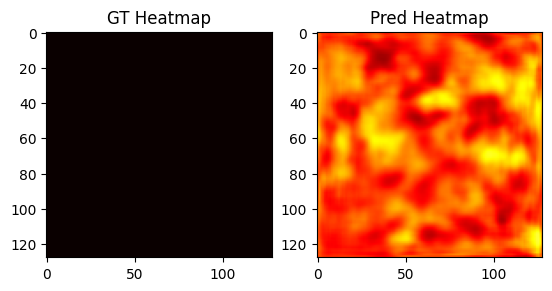


Epoch 1 completed in 492.21 seconds.
Train loss : 55.7786
Train mask loss : 55.6893
Train regr loss : 0.0089


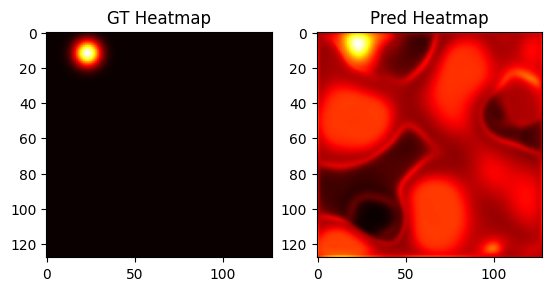


Validation loss      : 15.2872
Validation mask loss : 15.1358
Validation regr loss : 0.0151
Precision:        0.0000
Recall:           0.0000
F1 Score:         0.0000
FROC Score:       0.0000
Current Learning Rate: 0.0001
F1 Score improved from -inf to 0.0000

Epoch 2/100

Epoch 2 completed in 479.86 seconds.
Train loss : 1.4796
Train mask loss : 1.4457
Train regr loss : 0.0034

Validation loss      : 3.6315
Validation mask loss : 3.6203
Validation regr loss : 0.0011
Precision:        0.0000
Recall:           0.0000
F1 Score:         0.0000
FROC Score:       0.0000
Current Learning Rate: 0.0001
No improvement in F1 Score for 1 epoch(s)

Epoch 3/100


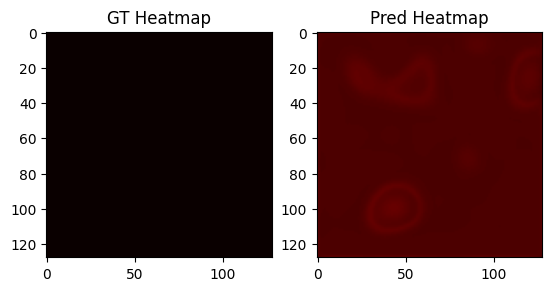


Epoch 3 completed in 480.00 seconds.
Train loss : 1.2067
Train mask loss : 1.1815
Train regr loss : 0.0025


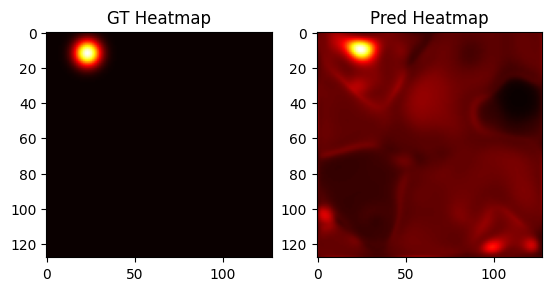


Validation loss      : 3.7116
Validation mask loss : 3.6989
Validation regr loss : 0.0013
Precision:        0.0000
Recall:           0.0000
F1 Score:         0.0000
FROC Score:       0.0000
Current Learning Rate: 0.0001
No improvement in F1 Score for 2 epoch(s)

Epoch 4/100

Epoch 4 completed in 478.40 seconds.
Train loss : 1.0270
Train mask loss : 1.0066
Train regr loss : 0.0020

Validation loss      : 2.7980
Validation mask loss : 2.7904
Validation regr loss : 0.0008
Precision:        0.6197
Recall:           0.0237
F1 Score:         0.0457
FROC Score:       0.0079
Current Learning Rate: 0.0001
F1 Score improved from 0.0000 to 0.0457

Epoch 5/100


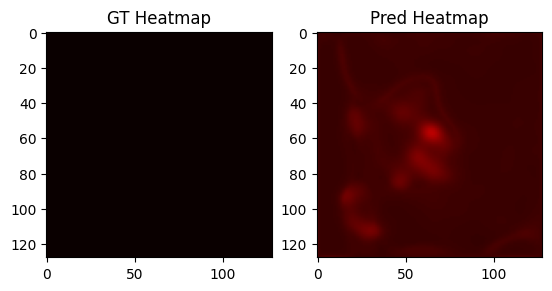


Epoch 5 completed in 496.53 seconds.
Train loss : 0.9046
Train mask loss : 0.8835
Train regr loss : 0.0021


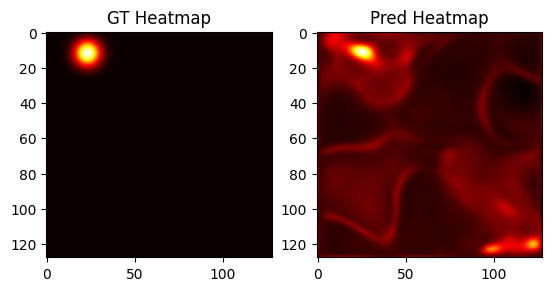


Validation loss      : 4.3305
Validation mask loss : 4.3154
Validation regr loss : 0.0015
Precision:        0.4184
Recall:           0.0318
F1 Score:         0.0592
FROC Score:       0.0115
Current Learning Rate: 0.0001
F1 Score improved from 0.0457 to 0.0592

Epoch 6/100

Epoch 6 completed in 495.69 seconds.
Train loss : 0.8714
Train mask loss : 0.8519
Train regr loss : 0.0020

Validation loss      : 3.3194
Validation mask loss : 3.3122
Validation regr loss : 0.0007
Precision:        0.2992
Recall:           0.0631
F1 Score:         0.1043
FROC Score:       0.0304
Current Learning Rate: 0.0001
F1 Score improved from 0.0592 to 0.1043

Epoch 7/100


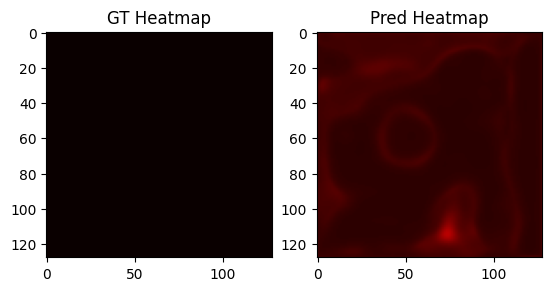


Epoch 7 completed in 496.83 seconds.
Train loss : 0.8116
Train mask loss : 0.7927
Train regr loss : 0.0019


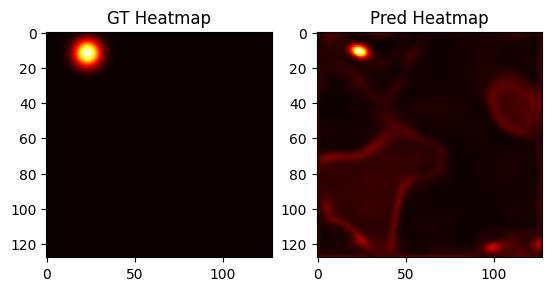


Validation loss      : 4.8401
Validation mask loss : 4.8324
Validation regr loss : 0.0008
Precision:        0.1975
Recall:           0.0594
F1 Score:         0.0913
FROC Score:       0.0309
Current Learning Rate: 0.0001
No improvement in F1 Score for 1 epoch(s)

Epoch 8/100

Epoch 8 completed in 480.33 seconds.
Train loss : 0.7263
Train mask loss : 0.7104
Train regr loss : 0.0016

Validation loss      : 3.2266
Validation mask loss : 3.2192
Validation regr loss : 0.0007
Precision:        0.4378
Recall:           0.1711
F1 Score:         0.2460
FROC Score:       0.0851
Current Learning Rate: 2.5e-05
F1 Score improved from 0.1043 to 0.2460

Epoch 9/100


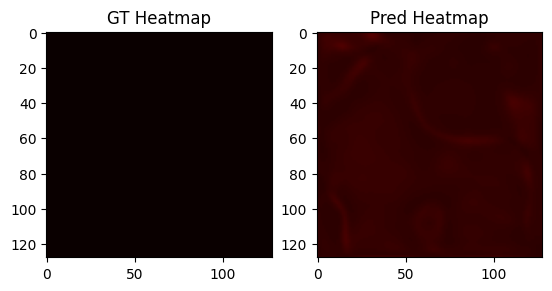


Epoch 9 completed in 496.91 seconds.
Train loss : 0.5935
Train mask loss : 0.5798
Train regr loss : 0.0014


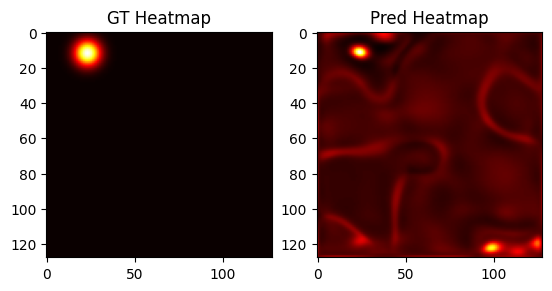


Validation loss      : 2.1187
Validation mask loss : 2.1119
Validation regr loss : 0.0007
Precision:        0.5574
Recall:           0.1101
F1 Score:         0.1839
FROC Score:       0.0505
Current Learning Rate: 2.5e-05
No improvement in F1 Score for 1 epoch(s)

Epoch 10/100

Epoch 10 completed in 478.56 seconds.
Train loss : 0.5563
Train mask loss : 0.5429
Train regr loss : 0.0013

Validation loss      : 4.4200
Validation mask loss : 4.4128
Validation regr loss : 0.0007
Precision:        0.3158
Recall:           0.1689
F1 Score:         0.2201
FROC Score:       0.0910
Current Learning Rate: 2.5e-05
No improvement in F1 Score for 2 epoch(s)

Epoch 11/100


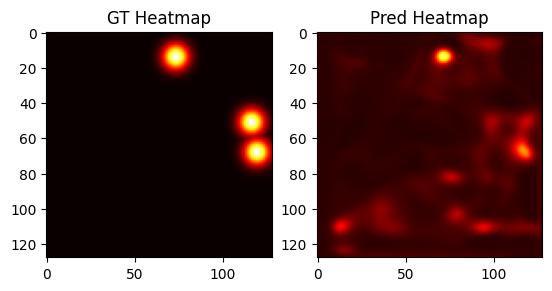


Epoch 11 completed in 480.27 seconds.
Train loss : 0.5567
Train mask loss : 0.5435
Train regr loss : 0.0013


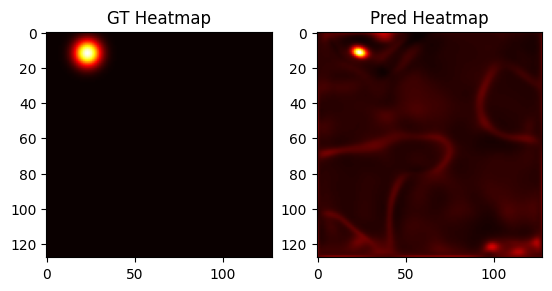


Validation loss      : 2.9009
Validation mask loss : 2.8940
Validation regr loss : 0.0007
Precision:        0.4882
Recall:           0.1786
F1 Score:         0.2616
FROC Score:       0.0890
Current Learning Rate: 2.5e-05
F1 Score improved from 0.2460 to 0.2616

Epoch 12/100

Epoch 12 completed in 496.08 seconds.
Train loss : 0.5649
Train mask loss : 0.5515
Train regr loss : 0.0013

Validation loss      : 3.8425
Validation mask loss : 3.8355
Validation regr loss : 0.0007
Precision:        0.4352
Recall:           0.2137
F1 Score:         0.2866
FROC Score:       0.1124
Current Learning Rate: 2.5e-05
F1 Score improved from 0.2616 to 0.2866

Epoch 13/100


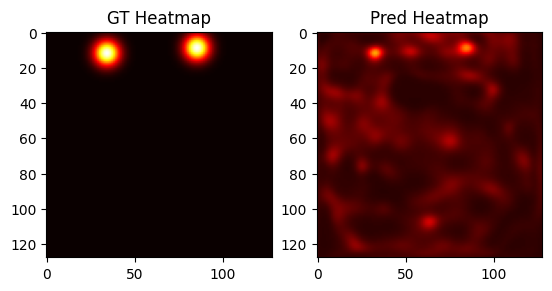


Epoch 13 completed in 495.79 seconds.
Train loss : 0.5013
Train mask loss : 0.4883
Train regr loss : 0.0013


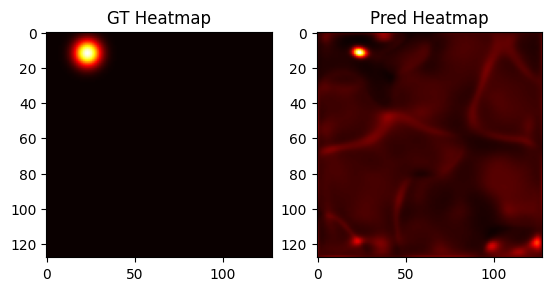


Validation loss      : 2.5826
Validation mask loss : 2.5757
Validation regr loss : 0.0007
Precision:        0.4358
Recall:           0.2180
F1 Score:         0.2906
FROC Score:       0.1234
Current Learning Rate: 6.25e-06
F1 Score improved from 0.2866 to 0.2906

Epoch 14/100

Epoch 14 completed in 496.06 seconds.
Train loss : 0.4946
Train mask loss : 0.4819
Train regr loss : 0.0013

Validation loss      : 2.7581
Validation mask loss : 2.7512
Validation regr loss : 0.0007
Precision:        0.4567
Recall:           0.1964
F1 Score:         0.2747
FROC Score:       0.1034
Current Learning Rate: 6.25e-06
No improvement in F1 Score for 1 epoch(s)

Epoch 15/100


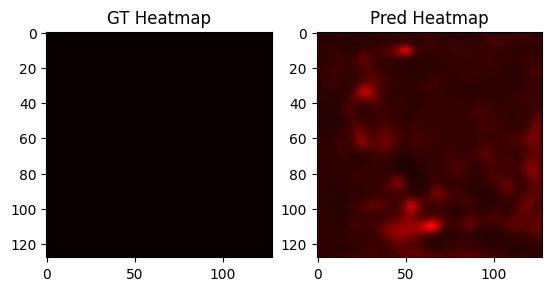


Epoch 15 completed in 479.91 seconds.
Train loss : 0.4831
Train mask loss : 0.4705
Train regr loss : 0.0013


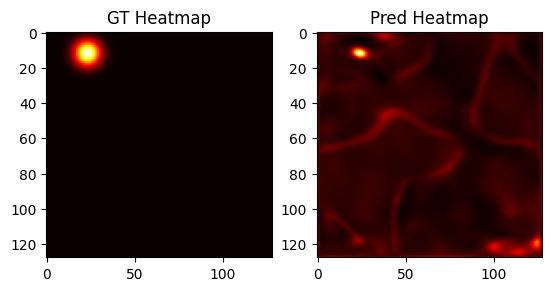


Validation loss      : 1.6360
Validation mask loss : 1.6290
Validation regr loss : 0.0007
Precision:        0.4648
Recall:           0.1819
F1 Score:         0.2614
FROC Score:       0.0984
Current Learning Rate: 6.25e-06
No improvement in F1 Score for 2 epoch(s)

Epoch 16/100

Epoch 16 completed in 479.15 seconds.
Train loss : 0.4784
Train mask loss : 0.4657
Train regr loss : 0.0013

Validation loss      : 2.5637
Validation mask loss : 2.5566
Validation regr loss : 0.0007
Precision:        0.4076
Recall:           0.2142
F1 Score:         0.2809
FROC Score:       0.1200
Current Learning Rate: 6.25e-06
No improvement in F1 Score for 3 epoch(s)

Epoch 17/100


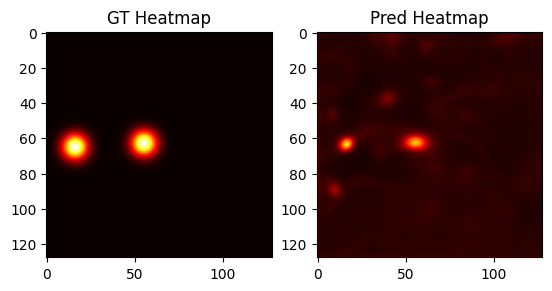


Epoch 17 completed in 479.99 seconds.
Train loss : 0.4678
Train mask loss : 0.4551
Train regr loss : 0.0013


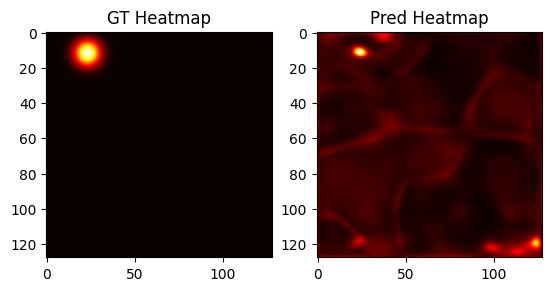


Validation loss      : 3.4177
Validation mask loss : 3.4106
Validation regr loss : 0.0007
Precision:        0.4102
Recall:           0.2035
F1 Score:         0.2720
FROC Score:       0.1112
Current Learning Rate: 6.25e-06
No improvement in F1 Score for 4 epoch(s)

Epoch 18/100

Epoch 18 completed in 477.95 seconds.
Train loss : 0.4611
Train mask loss : 0.4487
Train regr loss : 0.0012

Validation loss      : 3.0151
Validation mask loss : 3.0081
Validation regr loss : 0.0007
Precision:        0.4215
Recall:           0.2013
F1 Score:         0.2725
FROC Score:       0.1096
Current Learning Rate: 6.25e-06
No improvement in F1 Score for 5 epoch(s)

Epoch 19/100


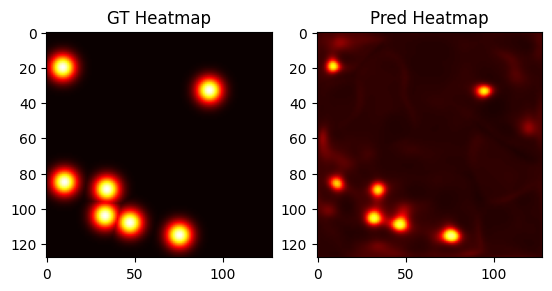


Epoch 19 completed in 480.23 seconds.
Train loss : 0.4657
Train mask loss : 0.4534
Train regr loss : 0.0012


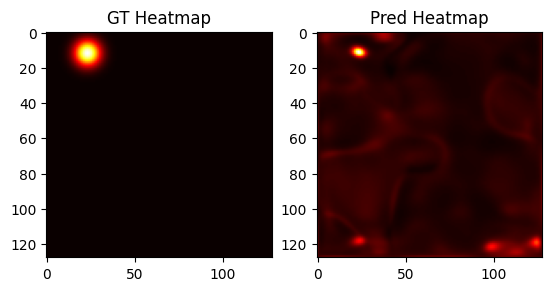


Validation loss      : 2.7694
Validation mask loss : 2.7625
Validation regr loss : 0.0007
Precision:        0.4201
Recall:           0.2056
F1 Score:         0.2761
FROC Score:       0.1155
Current Learning Rate: 1.5625e-06
No improvement in F1 Score for 6 epoch(s)

Epoch 20/100

Epoch 20 completed in 479.87 seconds.
Train loss : 0.4794
Train mask loss : 0.4668
Train regr loss : 0.0013

Validation loss      : 4.1689
Validation mask loss : 4.1620
Validation regr loss : 0.0007
Precision:        0.3903
Recall:           0.2342
F1 Score:         0.2927
FROC Score:       0.1371
Current Learning Rate: 1.5625e-06
F1 Score improved from 0.2906 to 0.2927

Epoch 21/100


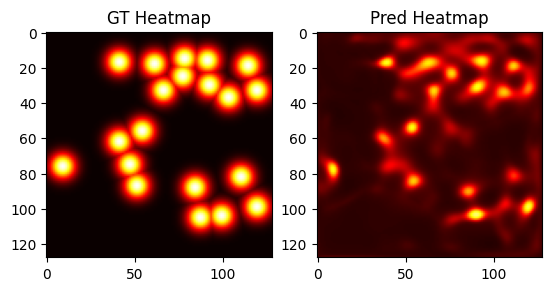


Epoch 21 completed in 496.91 seconds.
Train loss : 0.4548
Train mask loss : 0.4425
Train regr loss : 0.0012


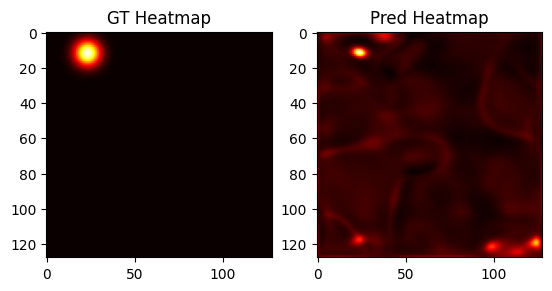


Validation loss      : 2.1998
Validation mask loss : 2.1927
Validation regr loss : 0.0007
Precision:        0.4395
Recall:           0.2040
F1 Score:         0.2787
FROC Score:       0.1130
Current Learning Rate: 1.5625e-06
No improvement in F1 Score for 1 epoch(s)

Epoch 22/100

Epoch 22 completed in 479.15 seconds.
Train loss : 0.4495
Train mask loss : 0.4371
Train regr loss : 0.0012

Validation loss      : 3.2656
Validation mask loss : 3.2586
Validation regr loss : 0.0007
Precision:        0.4053
Recall:           0.2240
F1 Score:         0.2885
FROC Score:       0.1252
Current Learning Rate: 1.5625e-06
No improvement in F1 Score for 2 epoch(s)

Epoch 23/100


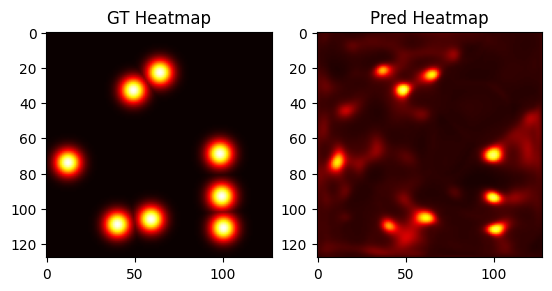


Epoch 23 completed in 480.51 seconds.
Train loss : 0.4491
Train mask loss : 0.4369
Train regr loss : 0.0012


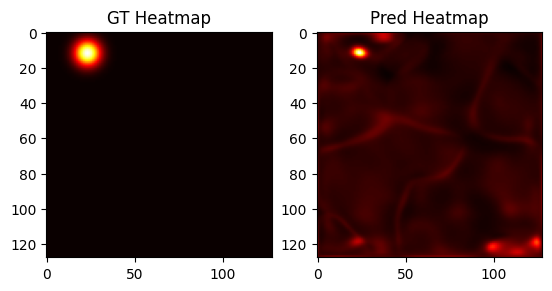


Validation loss      : 2.4699
Validation mask loss : 2.4629
Validation regr loss : 0.0007
Precision:        0.4129
Recall:           0.2035
F1 Score:         0.2726
FROC Score:       0.1130
Current Learning Rate: 3.90625e-07
No improvement in F1 Score for 3 epoch(s)

Epoch 24/100

Epoch 24 completed in 479.65 seconds.
Train loss : 0.4588
Train mask loss : 0.4463
Train regr loss : 0.0013

Validation loss      : 2.3939
Validation mask loss : 2.3868
Validation regr loss : 0.0007
Precision:        0.4384
Recall:           0.2035
F1 Score:         0.2779
FROC Score:       0.1140
Current Learning Rate: 3.90625e-07
No improvement in F1 Score for 4 epoch(s)

Epoch 25/100


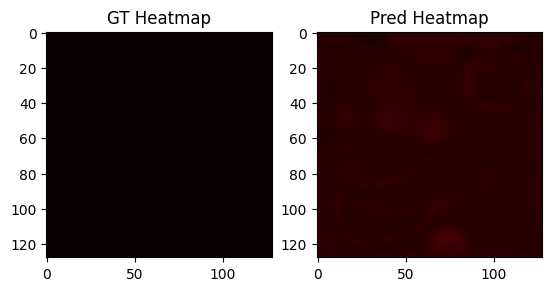


Epoch 25 completed in 477.70 seconds.
Train loss : 0.4444
Train mask loss : 0.4322
Train regr loss : 0.0012


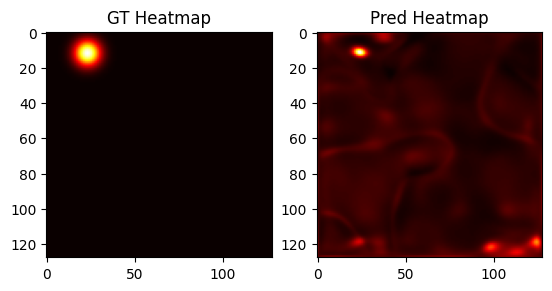


Validation loss      : 2.9439
Validation mask loss : 2.9368
Validation regr loss : 0.0007
Precision:        0.3902
Recall:           0.2234
F1 Score:         0.2841
FROC Score:       0.1308
Current Learning Rate: 3.90625e-07
No improvement in F1 Score for 5 epoch(s)

Epoch 26/100

Epoch 26 completed in 478.55 seconds.
Train loss : 0.4471
Train mask loss : 0.4348
Train regr loss : 0.0012

Validation loss      : 2.8248
Validation mask loss : 2.8178
Validation regr loss : 0.0007
Precision:        0.4036
Recall:           0.2169
F1 Score:         0.2822
FROC Score:       0.1229
Current Learning Rate: 3.90625e-07
No improvement in F1 Score for 6 epoch(s)

Epoch 27/100


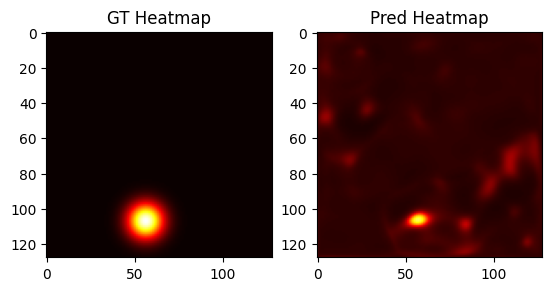


Epoch 27 completed in 479.78 seconds.
Train loss : 0.4497
Train mask loss : 0.4374
Train regr loss : 0.0012


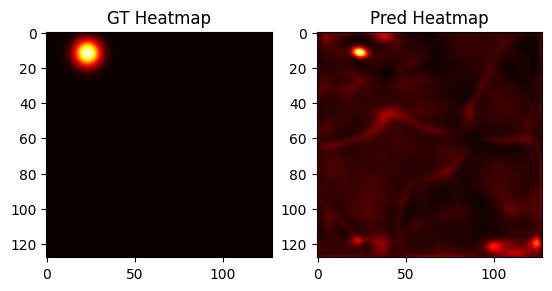


Validation loss      : 2.9053
Validation mask loss : 2.8983
Validation regr loss : 0.0007
Precision:        0.3942
Recall:           0.2110
F1 Score:         0.2749
FROC Score:       0.1203
Current Learning Rate: 1e-07
No improvement in F1 Score for 7 epoch(s)

Epoch 28/100

Epoch 28 completed in 478.61 seconds.
Train loss : 0.4717
Train mask loss : 0.4590
Train regr loss : 0.0013

Validation loss      : 3.1250
Validation mask loss : 3.1181
Validation regr loss : 0.0007
Precision:        0.4215
Recall:           0.2056
F1 Score:         0.2764
FROC Score:       0.1153
Current Learning Rate: 1e-07
No improvement in F1 Score for 8 epoch(s)

Epoch 29/100


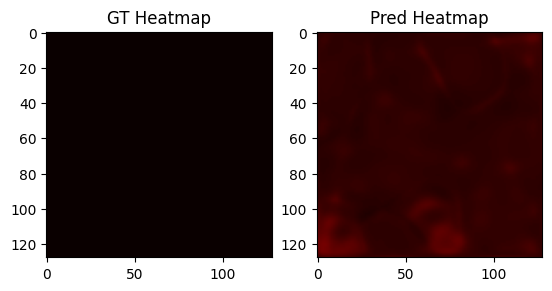


Epoch 29 completed in 479.12 seconds.
Train loss : 0.4523
Train mask loss : 0.4399
Train regr loss : 0.0012


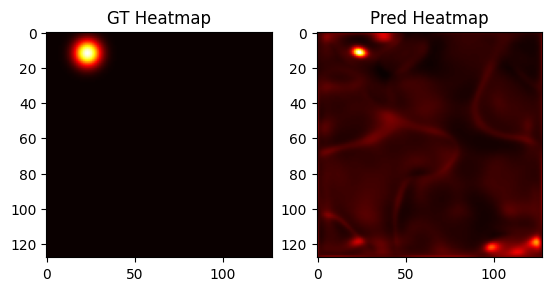


Validation loss      : 2.9031
Validation mask loss : 2.8961
Validation regr loss : 0.0007
Precision:        0.4270
Recall:           0.2051
F1 Score:         0.2771
FROC Score:       0.1160
Current Learning Rate: 1e-07
No improvement in F1 Score for 9 epoch(s)

Epoch 30/100

Epoch 30 completed in 478.67 seconds.
Train loss : 0.4568
Train mask loss : 0.4444
Train regr loss : 0.0012

Validation loss      : 3.0753
Validation mask loss : 3.0682
Validation regr loss : 0.0007
Precision:        0.4054
Recall:           0.2094
F1 Score:         0.2762
FROC Score:       0.1162
Current Learning Rate: 1e-07
No improvement in F1 Score for 10 epoch(s)
Early stopping triggered after 10 epochs without improvement.


In [34]:
# Get current timestamp (format: YYYYMMDD_HHMMSS)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create save directory with timestamp
save_dir = f'/content/drive/MyDrive/Dissertation_Chatwipa/model_checkpoint/student/adamw50_checkpoints_{timestamp}'
os.makedirs(save_dir, exist_ok=True)

# Initialize tracking variables
epochs = 100
best_loss = float('inf')
best_f1 = float('-inf')
epochs_no_improve = 0
early_stop_patience = 10
early_stop_flag = False

for epoch in range(epochs):
    early_stop_flag, best_loss, best_f1, epochs_no_improve = train_student(epoch, teacher_model, student_model,
                                                                           save_dir, best_loss, best_f1,
                                                                           epochs_no_improve, early_stop_patience)
    if early_stop_flag:
        break

## 4. Evaluation

#### Best model

In [29]:
model = centernet(model_name='resnet50')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model_path = "/content/drive/MyDrive/Dissertation_Chatwipa/model_checkpoint/student/adamw50_checkpoints_20250616_202915/best_model.pth"
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [30]:
save_dir = model_path.split('best_model.pth')[0]
metrics, froc, recall_list, csv_path = test(model, test_loader, device, save_dir)
print(f"Saved results to: {csv_path}")

Precision: 0.3495
Recall:    0.2052
F1 Score:  0.2585
FROC Score: 0.1187
Recalls by Threshold: {0.5: 0.20515394906119347, 0.7: 0.13855421682109967, 0.9: 0.01238286478835915}
Normal FP Score: 99.0000
Saved results to: /content/drive/MyDrive/Dissertation_Chatwipa/model_checkpoint/student/adamw50_checkpoints_20250616_202915/test_results.csv


#### 30 epochs model

In [31]:
model = centernet(model_name='resnet50')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model_path = "/content/drive/MyDrive/Dissertation_Chatwipa/model_checkpoint/student/adamw50_checkpoints_20250616_202915/checkpoint_epoch_30.pth"
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [32]:
save_dir = model_path.split('checkpoint_epoch_30.pth')[0]
metrics, froc, recall_list, csv_path = test(model, test_loader, device, save_dir)
print(f"Saved results to: {csv_path}")

Precision: 0.3797
Recall:    0.1854
F1 Score:  0.2492
FROC Score: 0.1058
Recalls by Threshold: {0.5: 0.18540829980408022, 0.7: 0.12148594373444246, 0.9: 0.010374832660517124}
Normal FP Score: 97.0000
Saved results to: /content/drive/MyDrive/Dissertation_Chatwipa/model_checkpoint/student/adamw50_checkpoints_20250616_202915/test_results.csv
